# Test de filtros FIR implementados en Python

## Importar herramientas

Importamos las herramientas que usaremos:

In [1]:
# Importación de librerías necesarias para el análisis de datos y procesamiento de señales.
import math   # Funciones matemáticas estándar
import numpy as np  # Operaciones numéricas avanzadas
import pandas as pd  # Manipulación de datos estructurados
import matplotlib.pyplot as plt  # Visualización de datos
import scipy  # Librería para cálculos científicos
from scipy.spatial.transform import Rotation as R  # Transformaciones espaciales
from scipy import signal  # Procesamiento de señales
from scipy.fft import fft, fftfreq  # Análisis de Fourier para señales
%matplotlib widget  



## Adquisición datos

Seleccionamos el .json para leer los datos:

In [2]:
df_Name = "JF" #Nombre del JSON sin formato

# Carga de datos desde el archivo JSON en un DataFrame de pandas
df = pd.read_json(df_Name + ".json")
# Creación del DataFrame con los valores de los sensores
df = pd.DataFrame(df["payload"]["values"], columns=[s["name"] for s in df["payload"]["sensors"]])
# Adición de la columna de tiempo en milisegundos (asumiendo intervalo de muestreo de 16 ms)
df['time'] = [i * 16 * 1e-3 for i in range(len(df))] 


Importamos los datos crudos:

In [3]:
# Asegurarse de que los datos de df son floats

# Definir los límites de tiempo para el análisis
t0 = 25
tf = len(df)

# Extraer datos específicos y convertirlos a tipo float
t = df["time"][t0:tf].to_numpy(dtype=float)  # Tiempo como float
a_x = df["accX"][t0:tf].to_numpy(dtype=float)  # Aceleración X
a_y = df["accY"][t0:tf].to_numpy(dtype=float)  # Aceleración Y
a_z = df["accZ"][t0:tf].to_numpy(dtype=float)  # Aceleración Z
yaw = df["yaw"][t0:tf].to_numpy(dtype=float)  # Yaw
gyro_x = df["gyroX"][t0:tf].to_numpy(dtype=float)  # Giro X (deg/s)
gyro_y = df["gyroY"][t0:tf].to_numpy(dtype=float)  # Giro Y (deg/s)
gyro_z = df["gyroZ"][t0:tf].to_numpy(dtype=float)  # Giro Z (deg/s)


#YAW presenta problemas, porque va de 0 a 360 en 5195

if df_Name == "Jenny":
    yaw[5196:] -= 360
    yaw[7275:] -= 360
elif df_Name == "JF":
    yaw[190:] -= 360
    yaw[4805:] -= 360
    yaw[6174:] -= 360
    print()
elif df_Name == "Julian":
    yaw[5196:] -= 0
    yaw[7275:] -= 0

pitch = df["pitch"].to_numpy(dtype=float)  # Pitch
roll = df["roll"].to_numpy(dtype=float)  # Roll


Graficamos los datos crudos:

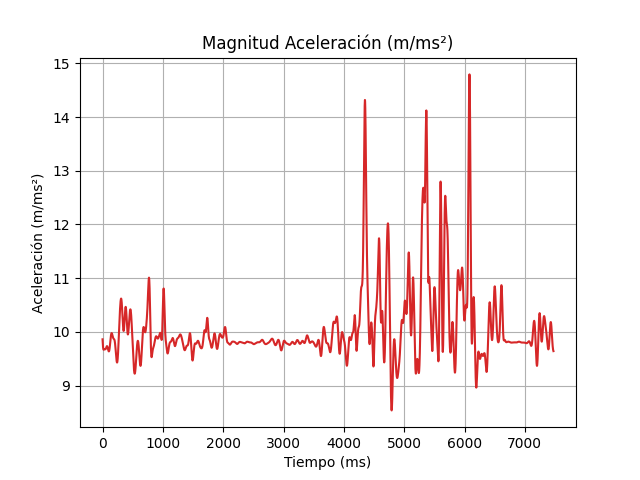

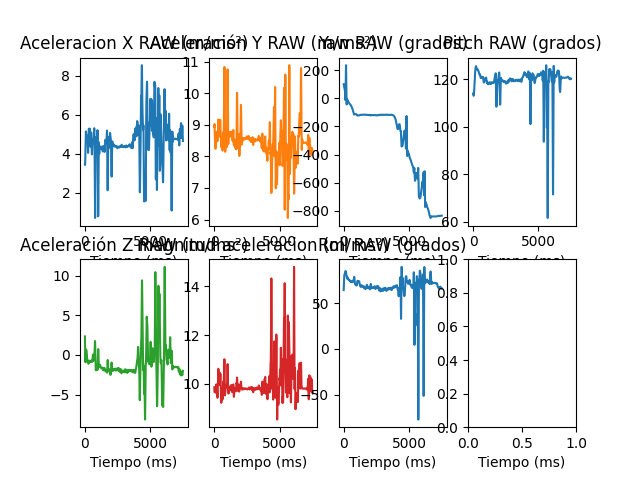

In [24]:
fig, axs_raw = plt.subplots(2, 4)
axs_raw[0, 0].plot(a_x)
axs_raw[0, 0].set_title('Aceleracion X RAW (m/ms²)')
axs_raw[0, 1].plot(a_y, 'tab:orange')
axs_raw[0, 1].set_title('Aceleración Y RAW (m/ms²)')
axs_raw[1, 0].plot(a_z, 'tab:green')
axs_raw[1, 0].set_title('Aceleración Z RAW (m/ms²)')
axs_raw[1, 1].plot( (a_x**2 + a_y**2 + a_z**2)**(1/2), 'tab:red')
axs_raw[1, 1].set_title('magnitud aceleracion (m/ms²)')

axs_raw[0, 2].plot(yaw)
axs_raw[0, 2].set_title('Yaw RAW (grados)')
axs_raw[0, 3].plot(pitch)
axs_raw[0, 3].set_title('Pitch RAW (grados)')
axs_raw[1, 2].plot(roll)
axs_raw[1, 2].set_title('Roll RAW (grados)')




for ax in axs_raw.flat:
    ax.set(xlabel='Tiempo (ms)', ylabel='')
    plt.grid()




mag_Acc_Graph = plt.figure()
plt.plot( range(0,len(a_x)),(a_x**2 + a_y**2 + a_z**2)**(1/2), 'tab:red')
plt.title('Magnitud Aceleración (m/ms²)')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Aceleración (m/ms²)')
plt.grid()

plt.show()


Realizamos un offset para quitar la gravedad:

In [5]:
gravedad = 1 #De 20 a 100
inicio_avg = 6800
fin_avg =  7000 #len(a_x)
average = True
# Eliminación del offset mediante promediado de datos
factor_offset = 0
if average:
    a_x_g = factor_offset* sum(a_x[inicio_avg:fin_avg])/len(a_x[inicio_avg:fin_avg])
    a_y_g = factor_offset* sum(a_y[inicio_avg:fin_avg])/len(a_y[inicio_avg:fin_avg])
    a_z_g = factor_offset* sum(a_z[inicio_avg:fin_avg])/len(a_z[inicio_avg:fin_avg])
    print ("true")
else:
    a_x_g = factor_offset*a_x[gravedad]
    a_y_g = factor_offset*a_y[gravedad]
    a_z_g = factor_offset*a_z[gravedad]
    print ("false")

for i in range(len(t)):
        a_x[i] -= a_x_g 
        a_y[i] -= a_y_g 
        a_z[i] -= a_z_g 
print( "a_x_g " + str(a_x_g) + " a_y_g " + str(a_y_g) + " a_z_g " + str(a_z_g) )
print((a_x_g**2 + a_y_g**2 + a_z_g**2)**(1/2))



true
a_x_g 0.0 a_y_g 0.0 a_z_g -0.0
0.0


Filtramos todas las variables con un filtro Butterworth de paso bajo:

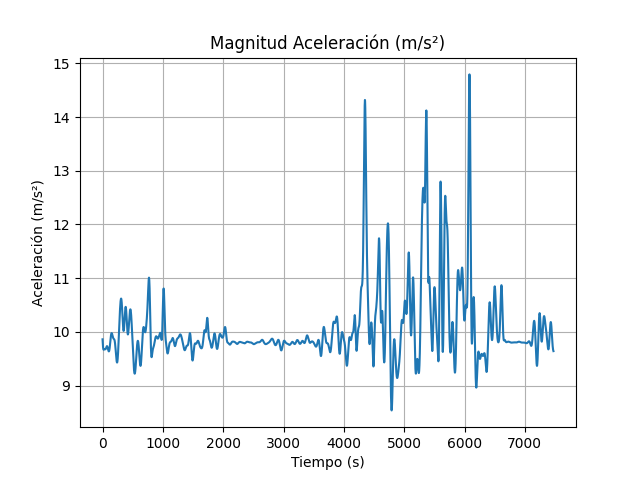

In [ ]:
# Definir la frecuencia de muestreo
Fs = 62.5

# Diseñar el filtro
cutoff_freq = 1 # Frecuencia de corte en Hz
order = 4  # Orden del filtro

# Normalizar la frecuencia de corte
normalized_cutoff = cutoff_freq / (Fs / 2)

# Crear el filtro Butterworth de paso bajo
b, a = signal.butter(order, normalized_cutoff, btype='low', analog=False)

# Aplicar el filtro a las señales
a_x = signal.filtfilt(b, a, a_x)
a_y = signal.filtfilt(b, a, a_y)
a_z = signal.filtfilt(b, a, a_z)
yaw = signal.filtfilt(b, a, yaw)
pitch = signal.filtfilt(b, a, pitch)
roll = signal.filtfilt(b, a, roll)
gyro_x = signal.filtfilt(b, a, gyro_x)
gyro_y = signal.filtfilt(b, a, gyro_y)
gyro_z = signal.filtfilt(b, a, gyro_z)

# Graficar la magnitud de la aceleración después del filtrado
mag_Acc_Graph = plt.figure()
plt.plot(range(0,len(a_x)), (a_x**2 + a_y**2 + a_z**2)**(1/2))
plt.title('Magnitud Aceleración (m/ms²)')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Aceleración (m/ms²)')
plt.grid()

plt.show()

                              


Observamos como se ven los datos filtrados:

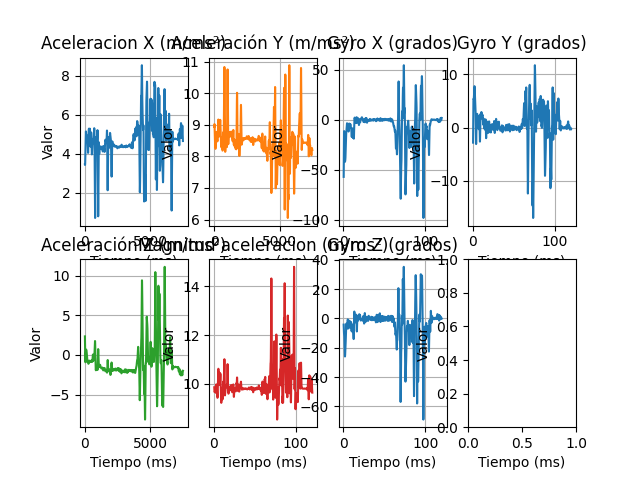

In [28]:
fig, axs = plt.subplots(2, 4)


axs[0, 0].plot(a_x)
axs[0, 0].set_title('Aceleracion X (m/ms²)')

axs[0, 0].grid()
axs[0, 1].plot(a_y, 'tab:orange')
axs[0, 1].set_title('Aceleración Y (m/ms²)')
axs[0, 1].grid()
axs[1, 0].plot(a_z, 'tab:green')
axs[1, 0].set_title('Aceleración Z (m/ms²)')
axs[1, 0].grid()

magnitud_Acc = (a_x**2 + a_y**2 + a_z**2)**(1/2)
axs[1, 1].plot(t,magnitud_Acc, 'tab:red')
axs[1, 1].set_title('Magnitud aceleracion (m/ms²)')
axs[1, 1].grid()
axs[0, 2].plot(t,gyro_x)
axs[0, 2].set_title('Gyro X (grados)')
axs[0, 2].grid()
axs[0, 3].plot(t,gyro_y)
axs[0, 3].set_title('Gyro Y (grados)')
axs[0, 3].grid()
axs[1, 2].plot(t,gyro_z)
axs[1, 2].set_title('Gyro Z (grados)')
axs[1, 2].grid()

for ax in axs.flat:
    ax.set(xlabel='Tiempo (ms)', ylabel='Valor')
    plt.grid()


Realizamos las proyecciones:

In [8]:
# Condiciones iniciales
v0 = np.array([0.0, 0.0, 0.0])  # Velocidad inicial
x0 = np.array([0.0, 0.0, 0.0])  # Posición inicial
orientacion = R.from_euler('zyx', [0, 0, 0], degrees=True)  # Orientación inicial (sin rotación)

# Almacenamiento de posiciones, aceleraciones y velocidades
posiciones = [x0]
a = np.array([0.0, 0.0, 0.0])
aceleraciones = [a]
velocidades = [v0.copy()]

# Definición de offsets para corrección de aceleración en cada eje
offset_x = 0
offset_y = 0
offset_z = 0

# Procesar cada paso de tiempo
for i in range(1,len(t)):
    dt = t[i] - t[i - 1]  # Delta tiempo
    # Calcular cambio de orientación a partir de las tasas de giro
    delta_rot = R.from_rotvec(np.radians([gyro_x[i] * dt, gyro_y[i] * dt, gyro_z[i] * dt]))
    orientacion = orientacion * delta_rot  # Actualizar orientación

    # Rotar aceleraciones al marco global
    a_global = orientacion.apply([a_x[i], a_y[i], a_z[i]])
    a_global[0] += offset_x
    a_global[1] += offset_y
    a_global[2] += offset_z
    
    #gravity_global = np.array([0, 0, 9.81])
    #a_global += gravity_global
    aceleraciones.append(a_global.copy())
    # Integrar para obtener velocidad y posición 
    v0 += a_global * dt
    velocidades.append(v0.copy())
    x0 += v0 * dt
    posiciones.append(x0.copy())

# Convertir a numpy array
posiciones = np.array(posiciones)
aceleraciones = np.array(aceleraciones)
velocidades = np.array(velocidades)


Observamos el resultado de las proyecciones:

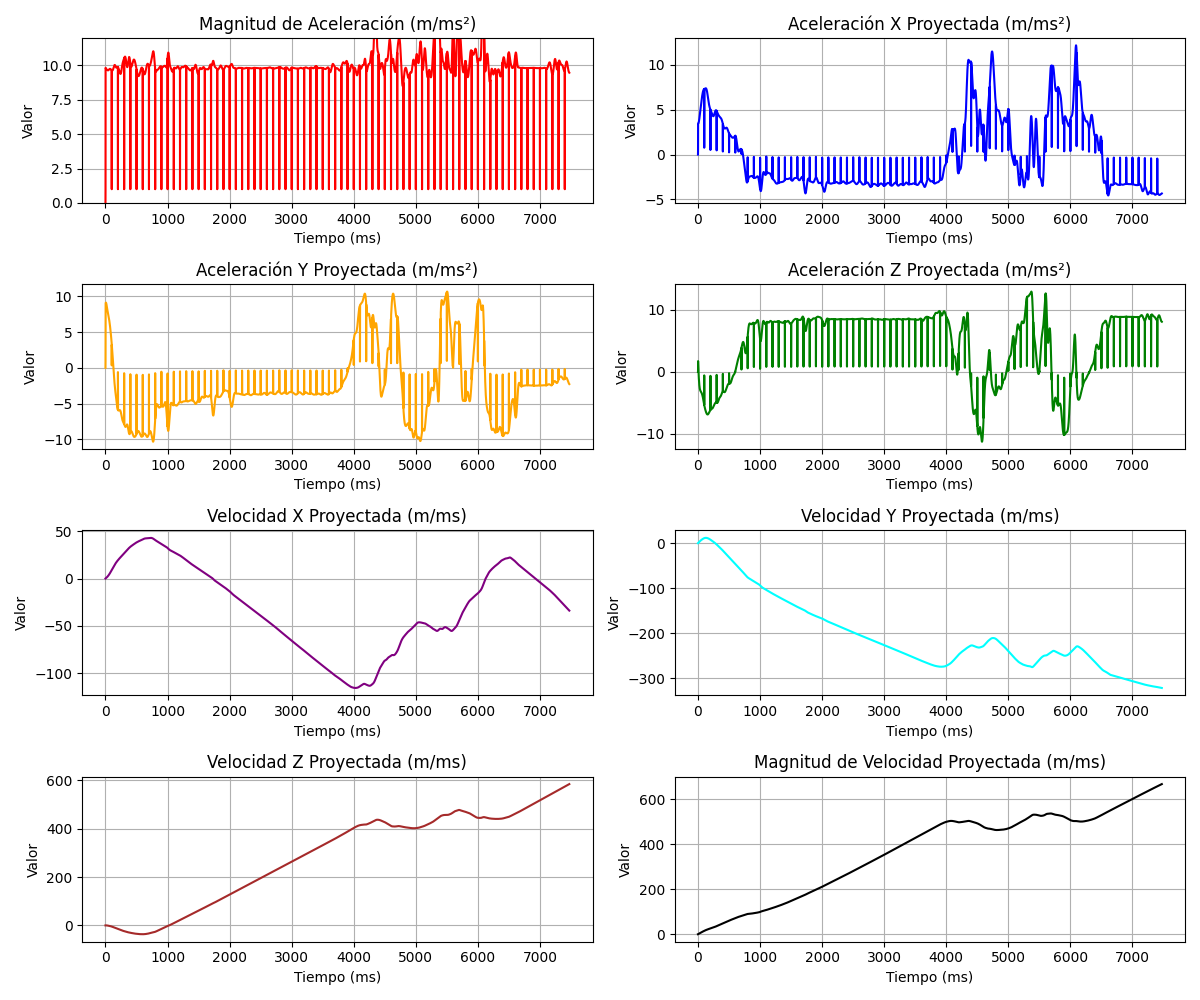

In [26]:
fig, axs5 = plt.subplots(4, 2, figsize=(12, 10))  # Ajustar tamaño de la figura

# Calcular la magnitud de la aceleración proyectada en los tres ejes
mag_Acc_Proy = ((aceleraciones[:, 0])**2 + (aceleraciones[:, 1])**2 + (aceleraciones[:, 2])**2)**(1/2)

# Calcular la magnitud de la velocidad proyectada (norma del vector)
mag_Vel_Proy = ((velocidades[:, 0])**2 + (velocidades[:, 1])**2 + (velocidades[:, 2])**2)**(1/2)

# Graficar la magnitud de la aceleración proyectada
axs5[0, 0].plot(range(len(mag_Acc_Proy)), mag_Acc_Proy, color='red')
axs5[0, 0].set_title('Magnitud de Aceleración (m/ms²)')
axs5[0, 0].set_ylim(0, 12)

# Graficar la aceleración proyectada en los ejes X, Y y Z
axs5[0, 1].plot(aceleraciones[:, 0], color='blue')
axs5[0, 1].set_title('Aceleración X Proyectada (m/ms²)')

axs5[1, 0].plot(aceleraciones[:, 1], color='orange')
axs5[1, 0].set_title('Aceleración Y Proyectada (m/ms²)')

axs5[1, 1].plot(aceleraciones[:, 2], color='green')
axs5[1, 1].set_title('Aceleración Z Proyectada (m/ms²)')

# Graficar la velocidad proyectada en los ejes X, Y y Z
axs5[2, 0].plot(velocidades[:, 0], color='purple')
axs5[2, 0].set_title('Velocidad X Proyectada (m/ms)')

axs5[2, 1].plot(velocidades[:, 1], color='cyan')
axs5[2, 1].set_title('Velocidad Y Proyectada (m/ms)')

axs5[3, 0].plot(velocidades[:, 2], color='brown')
axs5[3, 0].set_title('Velocidad Z Proyectada (m/ms)')

# Graficar la magnitud de la velocidad proyectada
axs5[3, 1].plot(mag_Vel_Proy, color='black')
axs5[3, 1].set_title('Magnitud de Velocidad Proyectada (m/ms)')

# Configuración común para todas las subgráficas
for ax in axs5.flat:
    ax.set(xlabel='Tiempo (ms)', ylabel='Valor')
    ax.grid(True)

# Ajustar el espacio entre subgráficas
plt.tight_layout()
plt.show()


Graficamos en 3d:

Magnitud de la gravedad calculada: 0.00 m/s²


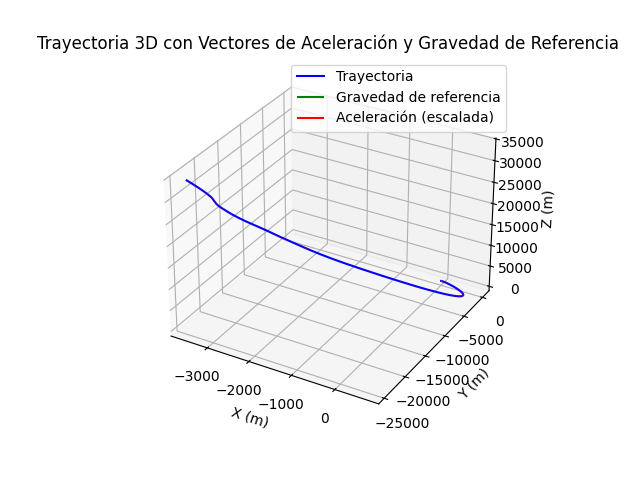

In [ ]:
# Graficar trayectoria en 3D
fig3d = plt.figure()
plt.clf()
ax3 = fig3d.add_subplot(111, projection='3d')

# Graficar la trayectoria en el espacio tridimensional
ax3.plot(posiciones[2:, 0], posiciones[2:, 1], posiciones[2:, 2], label='Trayectoria', color='blue')

###################################################################################################

# Mostrar la magnitud de la gravedad calculada a partir de las componentes corregidas
print(f'Magnitud de la gravedad calculada: {(a_x_g**2 + a_y_g**2 + a_z_g**2)**(1/2):.2f} m/s²')

# Visualizar la gravedad de referencia como un vector en el origen
k = 10  # Factor de escala
ax3.quiver(0, 0, 0, k * a_x_g, k * a_y_g, k * a_z_g, color='green', label='Gravedad de referencia')

###################################################################################################

# Graficar vectores de aceleración a lo largo de la trayectoria cada 100 puntos
for i in range(1, len(posiciones), 100):
    k = 10  # Factor de escala
    # Normalizar el vector de aceleración si no es nulo
    norm = (aceleraciones[i, 0]**2 + aceleraciones[i, 1]**2 + aceleraciones[i, 2]**2)**(1/2)
    if norm != 0:
        aceleraciones[i] /= norm
    ax3.quiver(
        posiciones[i, 0], posiciones[i, 1], posiciones[i, 2],
        k * aceleraciones[i, 0], k * aceleraciones[i, 1], k * aceleraciones[i, 2],
        color='red', label='Aceleración (escalada)' if i == 1 else None  # Evitar duplicados en la leyenda
    )

# Configurar etiquetas y leyendas
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_zlabel('Z (m)')
ax3.set_title('Trayectoria 3D con Vectores de Aceleración y Gravedad de Referencia')
ax3.legend()
plt.show()


Miramos la proyección en 3D:

1800372866.2057354


C:\Users\pipeh\AppData\Local\Temp\ipykernel_17908\383901128.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_proy = plt.figure()


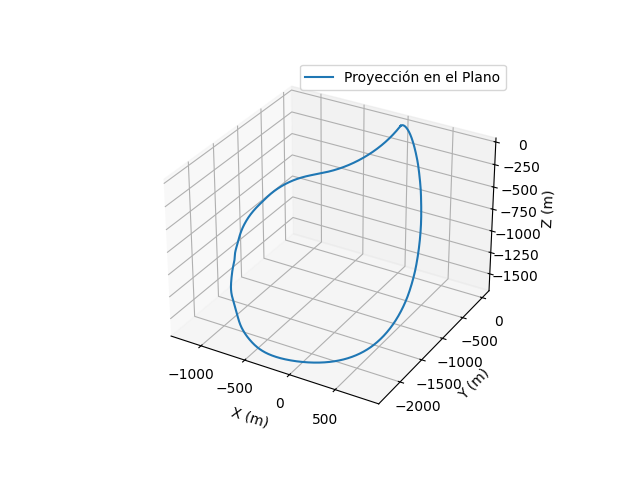

In [22]:
# Definir el plano: vector normal (A, B, C) y desplazamiento D
p_inicial = posiciones[1]
p_final =     posiciones[-1]
normal = p_final - p_inicial  # Vector normal al plano

D = 0  # Desplazamiento del plano

# Calcular la norma del vector normal
norm_sq = np.dot(normal, normal)
print(norm_sq)

# Crear lista para almacenar las posiciones proyectadas sobre el plano
proyecciones = []

# Proyectar cada punto de la trayectoria sobre el plano definido
for p in posiciones:
    # Proyección de cada punto en el plano
    dist_to_plane = (np.dot(normal, p) + D) / norm_sq
    proy = p - dist_to_plane * normal
    proyecciones.append(proy)

# Convertir a numpy array
proyecciones = np.array(proyecciones)

# Graficar posiciones originales y proyecciones en 3D
fig_proy = plt.figure()
plt.clf()
ax = fig_proy.add_subplot(111, projection='3d')
ax.plot(proyecciones[:, 0], proyecciones[:, 1], proyecciones[:, 2], label="Proyección en el Plano")

origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.legend()
plt.show()




Revisamos la proyeccion en el plano 2D:

Gráfico guardado en: ./proyecciones/JF_FC_10.png


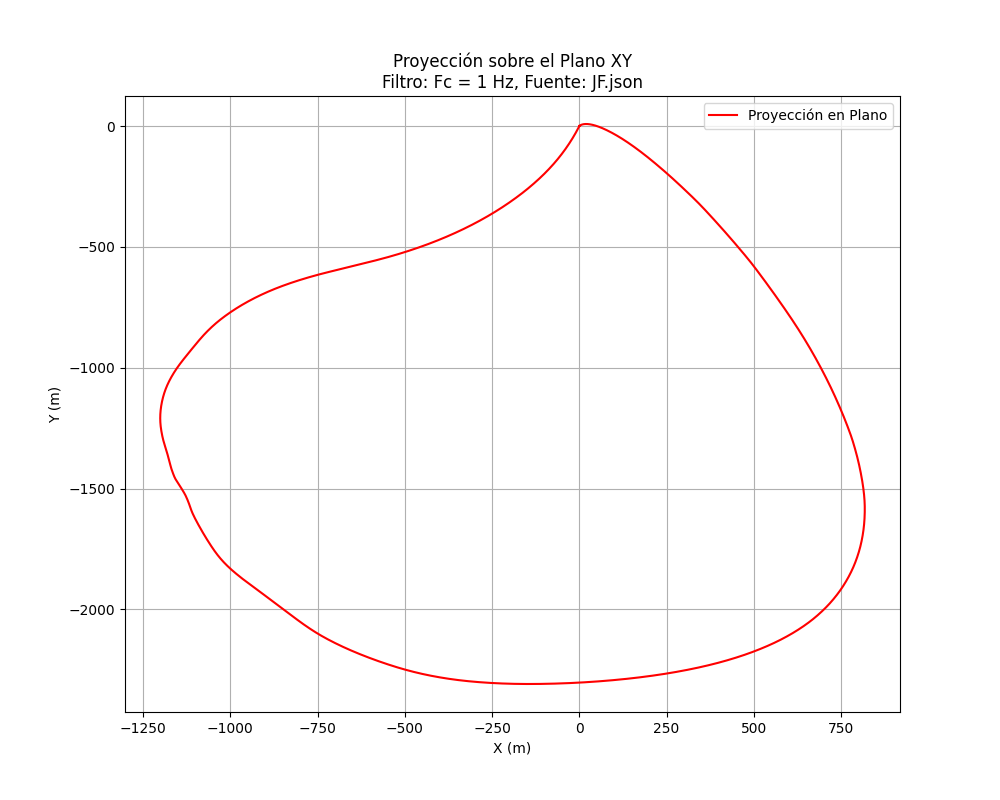

In [ ]:
# Calcular el vector normal como la diferencia de puntos seleccionados manualmente
# Calcular el desplazamiento D para que el plano pase por el primer punto
D = -np.dot(normal, p_inicial)  # Desplazamiento del plano para pasar por el punto inicial

# Crear una grilla para visualizar el plano en XY
x = np.linspace(-900, 50, 50)
y = np.linspace(-120, 2300, 50)
X, Y = np.meshgrid(x, y)

# Resolver Z en términos de X e Y
if normal[2] != 0:
    Z = (-normal[0] * X - normal[1] * Y - D) / normal[2]
else:
    Z = np.zeros_like(X)  # Caso especial si el plano es paralelo al eje Z

# Graficar las proyecciones y el plano
fig_2d = plt.figure(figsize=(10, 8))

# Graficar la proyección sobre el plano XY
plt.plot(proyecciones[:, 0], proyecciones[:, 1], c='red', label='Proyección en Plano')

# Configurar el gráfico
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title(f"Proyección sobre el Plano XY\nFiltro: Fc = {cutoff_freq} Hz, Fuente: {df_Name}.json")
plt.legend()
plt.grid(True)

# Guardar el gráfico
output_path = f"./proyecciones/{df_Name}_FC_{int(cutoff_freq * 10)}.png"
plt.savefig(output_path)
print(f"Gráfico guardado en: {output_path}")

# Mostrar el gráfico
plt.show()
